# College Finder Agent using LangGraph
Created with Cursor Prompt: create a jupyter notebook that creates a langgraph agent that helps find colleges that meet certain criteria


This notebook demonstrates how to create an agent using LangGraph that helps find colleges based on specific criteria like:
- Location
- Cost
- Academic programs
- Size
- Admission requirements
- And more...

In [1]:
import sys
from typing import List, Dict, Any, Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.output_parsers.openai_functions import PydanticAttrOutputFunctionsParser
from langgraph.graph import StateGraph, END
from langgraph.prebuilt.tool_executor import ToolExecutor

# Add src to path for imports
sys.path.append('../src')
from agents.llmtools import get_llm
from agents.tools.searchweb import search_web_with_query

# Load environment variables
load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


INFO     [browser_use] BrowserUse logging setup complete with level info
INFO     [root] Anonymized telemetry enabled. See https://github.com/gregpr07/browser-use for more information.


True

## Define Data Models

First, let's define our Pydantic models for college data and search criteria.

In [29]:


class CollegeCriteria(BaseModel):
    location: str = Field(description="Desired location (state, region, etc)")
    max_tuition: float = Field(description="Maximum yearly tuition in USD")
    desired_major: str = Field(description="Desired major or program of study")
    min_acceptance_rate: float = Field(description="Minimum acceptance rate as percentage", default=0.0)
    max_acceptance_rate: float = Field(description="Maximum acceptance rate as percentage", default=100.0)
    min_enrollment: int = Field(description="Minimum student enrollment", default=0)
    max_enrollment: int = Field(description="Maximum student enrollment", default=100000)

class College(BaseModel):
    name: str = Field(description="Name of the college")
    location: str = Field(description="Location of the college")
    tuition: float = Field(description="Yearly tuition in USD")
    acceptance_rate: float = Field(description="Acceptance rate as percentage")
    enrollment: int = Field(description="Total student enrollment")
    programs: List[str] = Field(description="List of notable academic programs")
    website: str = Field(description="College website URL")

class CollegeList(BaseModel):
    colleges: List[College]

class AgentState(BaseModel):
    messages: List[BaseMessage] = Field(default_factory=list)
    criteria: CollegeCriteria = None
    colleges: CollegeList = Field(default=None)
    current_step: str = Field(default="gather_criteria")

## Define Agent Tools and Functions

In [39]:

def search_colleges(criteria: CollegeCriteria) -> CollegeList:
    """Search for colleges matching the given criteria using web search"""
    query = f"colleges in {criteria.location} with {criteria.desired_major} program tuition under {criteria.max_tuition}"
    
    # Use web search tool
    search_results = search_web_with_query(query)

    print(f"Found {len(search_results)} search results")
    print("Search results: ", search_results)
    
    # Process results with LLM to extract structured college data
    llm = get_llm()
    structured_llm = llm.with_structured_output(CollegeList)
    
    prompt = f"""Based on these search results, extract information about colleges that match these criteria:
    - Location: {criteria.location}
    - Maximum tuition: ${criteria.max_tuition:,.2f}
    - Desired major: {criteria.desired_major}
    - Acceptance rate range: {criteria.min_acceptance_rate}% - {criteria.max_acceptance_rate}%
    - Enrollment range: {criteria.min_enrollment:,} - {criteria.max_enrollment:,}
    
    Search results:
    {search_results}
    """
    
    colleges = structured_llm.invoke(prompt)
    print(f"Found {len(colleges.colleges)} colleges")
    print("Colleges: ", colleges)
    return colleges

def analyze_matches(colleges: CollegeList, criteria: CollegeCriteria) -> str:
    """Analyze how well colleges match the criteria and generate recommendations"""
    llm = get_llm()
    
    prompt = f"""Analyze these colleges against the given criteria and provide recommendations:
    
    Criteria:
    {criteria.model_dump_json(indent=2)}
    
    Colleges:
    {[college.model_dump() for college in colleges.colleges]}
    
    Provide a concise analysis of the top matches and why they're good fits.
    """
    
    response = llm.invoke(prompt)
    print("Analysis: ", response.content)
    return response

## Build the LangGraph Agent

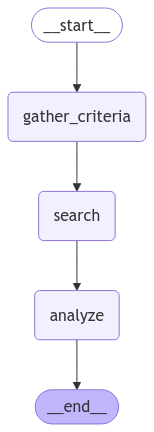

In [40]:
from IPython.display import Image, display


def gather_criteria(state: AgentState) -> AgentState:
    """Node to gather and validate college search criteria"""
    llm = get_llm()
    structured_llm = llm.with_structured_output(CollegeCriteria)
    
    # Get the last user message
    last_msg = state.messages[-1].content
    
    prompt = f"""Extract college search criteria from this message. If any criteria are missing, use reasonable defaults:
    {last_msg}
    """
    
    criteria = structured_llm.invoke(prompt)
    print("Criteria: ", criteria)
    state.criteria = criteria
    state.current_step = "search"
    return state

def search(state: AgentState) -> AgentState:
    """Node to search for matching colleges"""
    colleges = search_colleges(state.criteria)
    state.colleges = colleges
    state.current_step = "analyze"
    return state

def analyze(state: AgentState) -> AgentState:
    """Node to analyze results and make recommendations"""
    analysis = analyze_matches(state.colleges, state.criteria)
    state.messages.append(AIMessage(content=analysis))
    return state

# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("gather_criteria", gather_criteria)
workflow.add_node("search", search)
workflow.add_node("analyze", analyze)

# Add edges
workflow.add_edge("gather_criteria", "search")
workflow.add_edge("search", "analyze")
workflow.add_edge("analyze", END)

# Set entry point
workflow.set_entry_point("gather_criteria")

# Compile
agent = workflow.compile()
# Generate and display graph visualization


display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


## Test the Agent

Let's test our college finder agent with some example queries.

In [41]:
# Initialize state with a test query
initial_state = AgentState(
    messages=[HumanMessage(content="I'm looking for colleges in New York with computer science programs, tuition under $40,000 per year, and preferably medium-sized schools with acceptance rates between 30-70%.")]
)
# Run the agent
try:
    final_state = agent.invoke(initial_state)
    # Print the results
    print("Agent's Analysis:")
    print(final_state.messages[-1].content)
except Exception as e:
    import traceback
    print(f"Error running agent: {str(e)}")
    print("\nFull traceback:")
    print(traceback.format_exc())

Criteria:  location='New York' max_tuition=40000.0 desired_major='computer science' min_acceptance_rate=30.0 max_acceptance_rate=70.0 min_enrollment=500 max_enrollment=15000
Search results:  [SearchResult(link='https://www.franklin.edu/colleges-near/new-york/computer-science-degrees', content='CUNY York College is an institutionally accredited public school where most students attend classes full-time. CUNY New York City College of Technology is an institutionally accredited public school where most students attend classes full-time. CUNY Queensborough Community College is an institutionally accredited for profit school where most students attend classes full-time. CUNY Kingsborough Community College is an institutionally accredited for profit school where most students attend classes full-time. SUNY Westchester Community College is an institutionally accredited for profit school where most students attend classes full-time. SUNY Broome Community College is an institutionally accredite